In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray

import mindspore as ms
from mindspore import nn, ops, Tensor, save_checkpoint, load_checkpoint

In [5]:
# 设置MindSpore运行模式与设备（例如 CPU 或 GPU）
ms.context.set_context(mode=ms.context.GRAPH_MODE, device_target="CPU")

# ========================= 数据准备 =========================
# 加载数据
data = pd.read_csv(r'D:\分类数据\去重催化分类内部数据集.csv', encoding='gbk')

# 标签编码函数
def encode_labels(labels):
    selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
    non_selective_map = {
        'βδ': [0, 1, 0, 1],
        'αβγδ': [1, 1, 1, 1]
    }
    selective_labels = []
    multi_labels = []
    for label in labels:
        if label in selective_map:
            selective_labels.append(selective_map[label])
            multi_labels.append([0, 0, 0, 0])
        else:
            selective_labels.append(4)
            multi_labels.append(non_selective_map[label])
    return np.array(selective_labels), np.array(multi_labels)

labels = data['labels']
selective_labels, multi_labels = encode_labels(labels)

[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:48.317.390 [mindspore\context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


In [6]:




# SMILES 转指纹（这里对每个 SMILES 得到 2048 维特征）
def smiles_to_features(smiles_list):
    features = []
    for smi in smiles_list:
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                arr = np.zeros((2048,), dtype=int)
                ConvertToNumpyArray(fp, arr)
                features.append(arr)
            else:
                features.append(np.zeros(2048))
        else:
            features.append(np.zeros(2048))
    return np.array(features)

fps = smiles_to_features(data['smiles'])

# 数据划分
X_train, X_test, y_sel_train, y_sel_test, y_multi_train, y_multi_test = train_test_split(
    fps, selective_labels, multi_labels, test_size=0.2, random_state=42
)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerator
[13:23:49] DEPRECATION WARNING: please use MorganGenerat

In [7]:
# ========================= 模型定义 =========================
# 自定义 Focal Loss（使用 MindSpore 实现）
class FocalLoss(nn.Cell):
    def __init__(self, alpha=1, gamma=7, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        # 使用内置的SoftmaxCrossEntropyWithLogits（sparse模式直接接受类别标签）
        self.ce = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='none')
        self.exp = ops.Exp()

    def construct(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = self.exp(-ce_loss)
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# 定义多任务模型（共享层 + 两个任务头）
class AdvancedMultiTaskMLP(nn.Cell):
    def __init__(self, input_dim, hidden_dim):
        super(AdvancedMultiTaskMLP, self).__init__()
        self.shared_layer = nn.SequentialCell([
            nn.Dense(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.7),
            nn.Dense(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(0.7),
            nn.Dense(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.7),
            nn.Dense(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(0.7)
        ])
        self.selective_head = nn.Dense(hidden_dim // 2, 5)  # 5个选择性类别
        self.multi_head = nn.Dense(hidden_dim // 2, 4)      # 4个多任务输出
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        shared = self.shared_layer(x)
        selective_out = self.selective_head(shared)
        multi_out = self.sigmoid(self.multi_head(shared))
        return selective_out, multi_out

In [8]:
# 模型实例化
model = AdvancedMultiTaskMLP(input_dim=2048, hidden_dim=1024)
criterion_selective = FocalLoss(alpha=1, gamma=7)
criterion_multi = nn.BCELoss()
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.0001, weight_decay=1e-4)
# 注意：CosineAnnealingLR 在 MindSpore 中未直接提供，如有需要可自行实现

# 为训练构建组合损失 Cell
class NetWithLoss(nn.Cell):
    def __init__(self, network, criterion_sel, criterion_multi):
        super(NetWithLoss, self).__init__()
        self.network = network
        self.criterion_sel = criterion_sel
        self.criterion_multi = criterion_multi

    def construct(self, x, y_sel, y_multi):
        sel_out, multi_out = self.network(x)
        loss_sel = self.criterion_sel(sel_out, y_sel)
        loss_multi = self.criterion_multi(multi_out, y_multi)
        return 0.7 * loss_sel + 0.3 * loss_multi

net_with_loss = NetWithLoss(model, criterion_selective, criterion_multi)
# 使用 TrainOneStepCell 封装训练步骤
train_net = nn.TrainOneStepCell(net_with_loss, optimizer)
train_net.set_train()

[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.223.33 [mindspore\nn\layer\basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.389.94 [mindspore\nn\layer\basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.623.30 [mindspore\nn\layer\basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.707.21 [mindspore\nn\layer\basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.120.069 [mindspore\nn\layer\basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.120.069 [mindspore\nn\layer\basi

TrainOneStepCell<
  (network): NetWithLoss<
    (network): AdvancedMultiTaskMLP<
      (shared_layer): SequentialCell<
        (0): Dense<input_channels=2048, output_channels=1024, has_bias=True>
        (1): ReLU<>
        (2): BatchNorm1d<num_features=1024, eps=1e-05, momentum=0.9, gamma=Parameter (name=network.shared_layer.2.gamma, shape=(1024,), dtype=Float32, requires_grad=True), beta=Parameter (name=network.shared_layer.2.beta, shape=(1024,), dtype=Float32, requires_grad=True), moving_mean=Parameter (name=network.shared_layer.2.moving_mean, shape=(1024,), dtype=Float32, requires_grad=False), moving_variance=Parameter (name=network.shared_layer.2.moving_variance, shape=(1024,), dtype=Float32, requires_grad=False)>
        (3): Dropout<keep_prob=0.7>
        (4): Dense<input_channels=1024, output_channels=2048, has_bias=True>
        (5): ReLU<>
        (6): BatchNorm1d<num_features=2048, eps=1e-05, momentum=0.9, gamma=Parameter (name=network.shared_layer.6.gamma, shape=(2048,), dt

In [9]:




# ========================= 训练 =========================
num_epochs = 500
early_stop_patience = 10
best_loss = np.inf
no_improve_epochs = 0

# 将数据转换为 MindSpore 张量
X_train_tensor = Tensor(X_train, ms.float32)
y_sel_train_tensor = Tensor(y_sel_train, ms.int32)
y_multi_train_tensor = Tensor(y_multi_train, ms.float32)
# 如果想将checkpoint保存到特定目录，请确保该目录存在
import os
save_dir = "./checkpoints/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
checkpoint_file = os.path.join(save_dir, 'best_model.ckpt')

for epoch in range(num_epochs):
    loss = train_net(X_train_tensor, y_sel_train_tensor, y_multi_train_tensor)
    loss_val = loss.asnumpy()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_val}")
    
    if loss_val < best_loss:
        best_loss = loss_val
        no_improve_epochs = 0
        save_checkpoint(model, 'best_model.ckpt')
    else:
        no_improve_epochs += 1
    
    if no_improve_epochs >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 加载最佳模型
load_checkpoint('best_model.ckpt', net=model)



[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.190.320 [mindspore\nn\layer\basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.190.860 [mindspore\nn\layer\basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.190.860 [mindspore\nn\layer\basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.190.860 [mindspore\nn\layer\basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.291.418 [mindspore\nn\layer\basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(18100:5400,MainProcess):2025-04-30-13:23:58.292.019 [mindspore\nn\layer\

Epoch 1/500, Loss: 0.6952763795852661
Epoch 2/500, Loss: 0.5878377556800842
Epoch 3/500, Loss: 0.521672248840332
Epoch 4/500, Loss: 0.46839141845703125
Epoch 5/500, Loss: 0.42771685123443604
Epoch 6/500, Loss: 0.39370009303092957
Epoch 7/500, Loss: 0.3703206479549408
Epoch 8/500, Loss: 0.3465728759765625
Epoch 9/500, Loss: 0.32737958431243896
Epoch 10/500, Loss: 0.3117877244949341
Epoch 11/500, Loss: 0.29927870631217957
Epoch 12/500, Loss: 0.28949710726737976
Epoch 13/500, Loss: 0.2799961566925049
Epoch 14/500, Loss: 0.2689719796180725
Epoch 15/500, Loss: 0.26495638489723206
Epoch 16/500, Loss: 0.26097986102104187
Epoch 17/500, Loss: 0.2529264986515045
Epoch 18/500, Loss: 0.24762213230133057
Epoch 19/500, Loss: 0.24224765598773956
Epoch 20/500, Loss: 0.2397155463695526
Epoch 21/500, Loss: 0.23494035005569458
Epoch 22/500, Loss: 0.23108328878879547
Epoch 23/500, Loss: 0.22659513354301453
Epoch 24/500, Loss: 0.22425886988639832
Epoch 25/500, Loss: 0.22060967981815338
Epoch 26/500, Loss: 

{'network.shared_layer.0.weight': Parameter (name=network.shared_layer.0.weight, shape=(1024, 2048), dtype=Float32, requires_grad=True),
 'network.shared_layer.0.bias': Parameter (name=network.shared_layer.0.bias, shape=(1024,), dtype=Float32, requires_grad=True),
 'network.shared_layer.2.moving_mean': Parameter (name=network.shared_layer.2.moving_mean, shape=(1024,), dtype=Float32, requires_grad=True),
 'network.shared_layer.2.moving_variance': Parameter (name=network.shared_layer.2.moving_variance, shape=(1024,), dtype=Float32, requires_grad=True),
 'network.shared_layer.2.gamma': Parameter (name=network.shared_layer.2.gamma, shape=(1024,), dtype=Float32, requires_grad=True),
 'network.shared_layer.2.beta': Parameter (name=network.shared_layer.2.beta, shape=(1024,), dtype=Float32, requires_grad=True),
 'network.shared_layer.4.weight': Parameter (name=network.shared_layer.4.weight, shape=(2048, 1024), dtype=Float32, requires_grad=True),
 'network.shared_layer.4.bias': Parameter (name=

In [10]:
# # ========================= 测试与评估 =========================
# model.set_train(False)
# X_test_tensor = Tensor(X_test, ms.float32)
# y_sel_test_tensor = Tensor(y_sel_test, ms.int32)
# y_multi_test_tensor = Tensor(y_multi_test, ms.float32)

# sel_out, multi_out = model(X_test_tensor)
# # 选择性任务：取输出中概率最大的类别
# selective_pred = ops.Argmax(axis=1)(sel_out).asnumpy()
# multi_pred = (multi_out.asnumpy() > 0.5).astype(int)

# # 使用 sklearn 计算分类报告
# target_names = ['α', 'β', 'γ', 'δ', 'Non-selective']
# report = classification_report(y_sel_test, selective_pred, target_names=target_names, output_dict=True)

# report_str = f"""
# Classification Report:
# {'-'*40}
# Category          Precision   Recall   F1-Score   Support
# """
# for label, metrics in report.items():
#     if label not in ['accuracy', 'macro avg', 'weighted avg']:
#         report_str += f"{label:<16} {metrics['precision']:.4f}   {metrics['recall']:.4f}   {metrics['f1-score']:.4f}   {int(metrics['support']):<8}\n"

# accuracy_val = report["accuracy"]
# macro_avg = report["macro avg"]
# weighted_avg = report["weighted avg"]
# report_str += f"""
# {'-'*40}
# Accuracy:         {accuracy_val:.4f}
# Macro Avg         {macro_avg['precision']:.4f}   {macro_avg['recall']:.4f}   {macro_avg['f1-score']:.4f}
# Weighted Avg      {weighted_avg['precision']:.4f}   {weighted_avg['recall']:.4f}   {weighted_avg['f1-score']:.4f}
# """
# print(report_str)

# # 绘制混淆矩阵
# cm = confusion_matrix(y_sel_test, selective_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()



Classification Report (Training Set):
----------------------------------------
Category          Precision   Recall   F1-Score   Support
α                0.9994   0.9975   0.9984   6378    
β                0.9650   0.9847   0.9747   196     
γ                0.9937   0.9906   0.9922   638     
δ                0.9994   0.9929   0.9962   5088    
Non-selective    0.9020   0.9975   0.9474   406     

----------------------------------------
Accuracy:         0.9951
Macro Avg         0.9719   0.9926   0.9818
Weighted Avg      0.9955   0.9951   0.9952



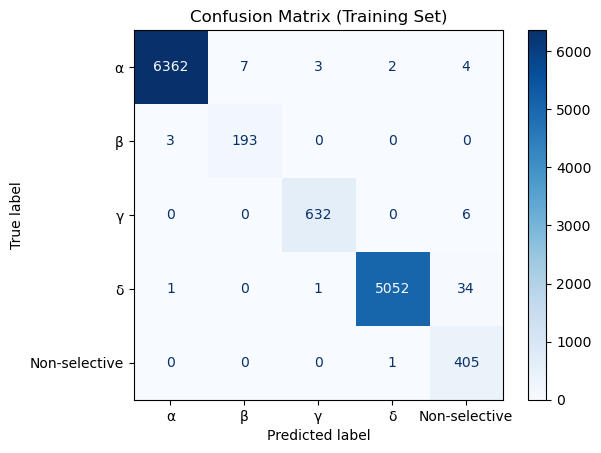

类别 α 的 ROC 曲线数据已保存到 D:\图数据\minspore多分类training_auc_data_class_α.csv
类别 β 的 ROC 曲线数据已保存到 D:\图数据\minspore多分类training_auc_data_class_β.csv
类别 γ 的 ROC 曲线数据已保存到 D:\图数据\minspore多分类training_auc_data_class_γ.csv
类别 δ 的 ROC 曲线数据已保存到 D:\图数据\minspore多分类training_auc_data_class_δ.csv
类别 Non-selective 的 ROC 曲线数据已保存到 D:\图数据\minspore多分类training_auc_data_class_Non-selective.csv


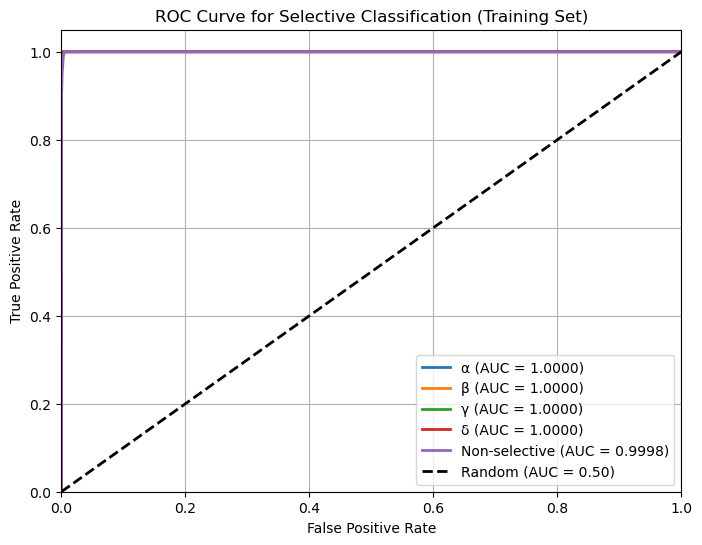

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from mindspore import Tensor, ops
import mindspore as ms

# ========================= 分类报告（训练集）=========================
# 模型设置为评估模式（关闭训练状态）
model.set_train(False)

# 将训练集数据转换为 Tensor
X_train_tensor = Tensor(X_train, ms.float32)
y_sel_train_tensor = Tensor(y_sel_train, ms.int32)
y_multi_train_tensor = Tensor(y_multi_train, ms.float32)

# 获取模型输出
sel_out, multi_out = model(X_train_tensor)

# 选择性任务：取输出中概率最大的类别作为预测结果
selective_pred = ops.Argmax(axis=1)(sel_out).asnumpy()
multi_pred = (multi_out.asnumpy() > 0.5).astype(int)

# 使用 sklearn 计算训练集分类报告
target_names = ['α', 'β', 'γ', 'δ', 'Non-selective']
report = classification_report(y_sel_train, selective_pred, target_names=target_names, output_dict=True)

# 格式化输出报告
report_str = f"""
Classification Report (Training Set):
{'-'*40}
Category          Precision   Recall   F1-Score   Support
"""
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        report_str += f"{label:<16} {metrics['precision']:.4f}   {metrics['recall']:.4f}   {metrics['f1-score']:.4f}   {int(metrics['support']):<8}\n"

accuracy_val = report["accuracy"]
macro_avg = report["macro avg"]
weighted_avg = report["weighted avg"]
report_str += f"""
{'-'*40}
Accuracy:         {accuracy_val:.4f}
Macro Avg         {macro_avg['precision']:.4f}   {macro_avg['recall']:.4f}   {macro_avg['f1-score']:.4f}
Weighted Avg      {weighted_avg['precision']:.4f}   {weighted_avg['recall']:.4f}   {weighted_avg['f1-score']:.4f}
"""
print(report_str)

# 绘制混淆矩阵
cm = confusion_matrix(y_sel_train, selective_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Training Set)')
plt.show()

# ========================= ROC 曲线（训练集）=========================
# 对于选择性任务，我们利用 softmax 将 logits 转换为概率（shape: (n_samples, 5)）
softmax = ops.Softmax(axis=1)
sel_probs = softmax(sel_out).asnumpy()

# 将训练集真实标签转换为 one-hot 编码
n_samples = y_sel_train_tensor.shape[0]
n_classes = 5
y_true_onehot = np.zeros((n_samples, n_classes))
for i, label in enumerate(y_sel_train):
    y_true_onehot[i, label] = 1

# 使用 sklearn 计算并绘制各类别 ROC 曲线及 AUC 值
fpr = {}
tpr = {}
roc_auc = {}
class_names = ['α', 'β', 'γ', 'δ', 'Non-selective']

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_true_onehot[:, i], sel_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')
    
    # 保存该类别的 ROC 数据到 CSV 文件
    auc_data = pd.DataFrame({
        'fpr': fpr[i],
        'tpr': tpr[i],
        'thresholds': thresholds
    })
    csv_filename = f"D:\图数据\minspore多分类training_auc_data_class_{class_names[i]}.csv"
    auc_data.to_csv(csv_filename, index=False)
    print(f"类别 {class_names[i]} 的 ROC 曲线数据已保存到 {csv_filename}")

# 绘制随机分类参考线
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Selective Classification (Training Set)')
plt.legend(loc="lower right")
plt.grid(True)
# plt.savefig("training_set_roc_curve.png")  # 保存整体 ROC 曲线图
plt.show()



Classification Report:
----------------------------------------
Category          Precision   Recall   F1-Score   Support
α                0.9395   0.9586   0.9490   1571    
β                0.9286   0.7091   0.8041   55      
γ                0.7770   0.7986   0.7877   144     
δ                0.9503   0.9329   0.9415   1312    
Non-selective    0.9375   0.9474   0.9424   95      

----------------------------------------
Accuracy:         0.9361
Macro Avg         0.9066   0.8693   0.8849
Weighted Avg      0.9363   0.9361   0.9359



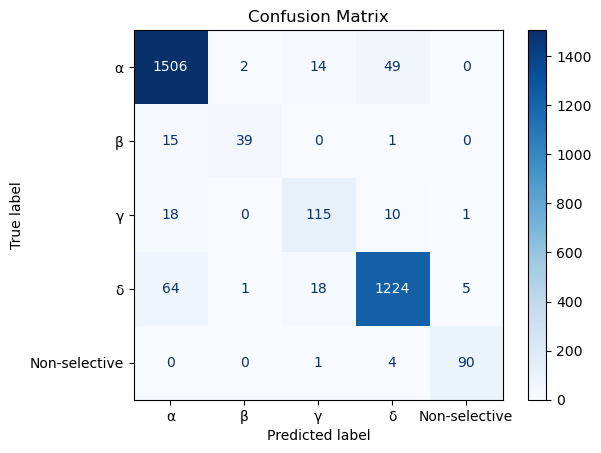

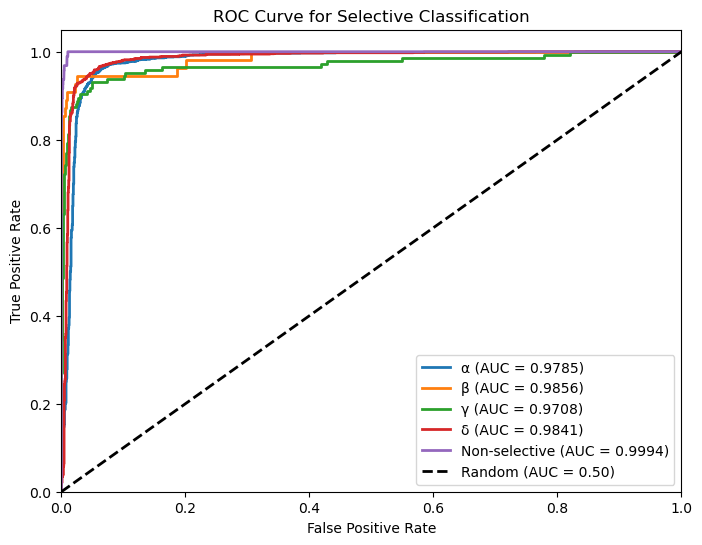

In [15]:
# ========================= 测试与评估 =========================
model.set_train(False)
X_test_tensor = Tensor(X_test, ms.float32)
y_sel_test_tensor = Tensor(y_sel_test, ms.int32)
y_multi_test_tensor = Tensor(y_multi_test, ms.float32)

sel_out, multi_out = model(X_test_tensor)
# 选择性任务：取输出中概率最大的类别
selective_pred = ops.Argmax(axis=1)(sel_out).asnumpy()
multi_pred = (multi_out.asnumpy() > 0.5).astype(int)

# 使用 sklearn 计算分类报告
target_names = ['α', 'β', 'γ', 'δ', 'Non-selective']
report = classification_report(y_sel_test, selective_pred, target_names=target_names, output_dict=True)

report_str = f"""
Classification Report:
{'-'*40}
Category          Precision   Recall   F1-Score   Support
"""
for label, metrics in report.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        report_str += f"{label:<16} {metrics['precision']:.4f}   {metrics['recall']:.4f}   {metrics['f1-score']:.4f}   {int(metrics['support']):<8}\n"

accuracy_val = report["accuracy"]
macro_avg = report["macro avg"]
weighted_avg = report["weighted avg"]
report_str += f"""
{'-'*40}
Accuracy:         {accuracy_val:.4f}
Macro Avg         {macro_avg['precision']:.4f}   {macro_avg['recall']:.4f}   {macro_avg['f1-score']:.4f}
Weighted Avg      {weighted_avg['precision']:.4f}   {weighted_avg['recall']:.4f}   {weighted_avg['f1-score']:.4f}
"""
print(report_str)

# 绘制混淆矩阵
cm = confusion_matrix(y_sel_test, selective_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ========================= ROC 曲线 =========================
# 对于选择性任务，利用 softmax 将 logits 转为概率
softmax = ops.Softmax(axis=1)
sel_probs = softmax(sel_out).asnumpy()  # shape: (n_samples, 5)

# 将真实标签转换为 one-hot 编码
n_samples = y_sel_test_tensor.shape[0]
y_true_onehot = np.zeros((n_samples, 5))
for i, label in enumerate(y_sel_test):
    y_true_onehot[i, label] = 1

# 计算并绘制各类别 ROC 曲线与 AUC
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = {}
class_names = ['α', 'β', 'γ', 'δ', 'Non-selective']

plt.figure(figsize=(8, 6))
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], sel_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

# 绘制随机分类参考线
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Selective Classification')
plt.legend(loc="lower right")
plt.show()


In [13]:
import pandas as pd

# ========================= 保存混淆矩阵数据 =========================
# 将混淆矩阵转换为 DataFrame，并添加行列标签
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
# 保存为 CSV 文件
cm_df.to_csv(r"D:\图数据\mindspore的多任务感知机测试confusion_matrix.csv", index=True)
print("Confusion matrix data saved to 'confusion_matrix.csv'.")

# ========================= 保存 ROC 曲线数据 =========================
# 对于每个类别保存 ROC 曲线的数据点 fpr 和 tpr 到单独的 CSV 文件
for i in range(5):
    df_roc = pd.DataFrame({
        "fpr": fpr[i],
        "tpr": tpr[i]
    })
    file_name = f"roc_curve_{class_names[i]}.csv"
    df_roc.to_csv(file_name, index=False)
    print(f"ROC curve data for class '{class_names[i]}' saved to '{file_name}'.")

# 同时保存各类别的 AUC 值到一个汇总 CSV 文件
auc_summary_df = pd.DataFrame({
    "Class": class_names,
    "AUC": [roc_auc[i] for i in range(5)]
})
auc_summary_df.to_csv(r"D:\图数据\mindspore的多任务感知机测试roc_auc_summary.csv", index=False)
print("ROC AUC summary saved to 'roc_auc_summary.csv'.")


Confusion matrix data saved to 'confusion_matrix.csv'.
ROC curve data for class 'α' saved to 'roc_curve_α.csv'.
ROC curve data for class 'β' saved to 'roc_curve_β.csv'.
ROC curve data for class 'γ' saved to 'roc_curve_γ.csv'.
ROC curve data for class 'δ' saved to 'roc_curve_δ.csv'.
ROC curve data for class 'Non-selective' saved to 'roc_curve_Non-selective.csv'.
ROC AUC summary saved to 'roc_auc_summary.csv'.


[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerator
[14:16:59] DEPRECATION WARNING: please use MorganGenerat

外部验证集分类报告:
              precision    recall  f1-score   support

                 0.0000    0.0000    0.0000         0
           α     0.9366    0.9536    0.9450       883
        αβγδ     1.0000    1.0000    1.0000        44
           β     0.5588    0.6786    0.6129        28
          βδ     0.7500    0.7500    0.7500        12
           γ     0.8088    0.6627    0.7285        83
           δ     0.9681    0.9394    0.9535       710

    accuracy                         0.9295      1760
   macro avg     0.7175    0.7120    0.7128      1760
weighted avg     0.9376    0.9295    0.9330      1760



E:\anaconda\envs\huawei\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\huawei\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\huawei\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\anaconda\envs\huawei\lib\site-packages\IPython\core\pylabtools.p

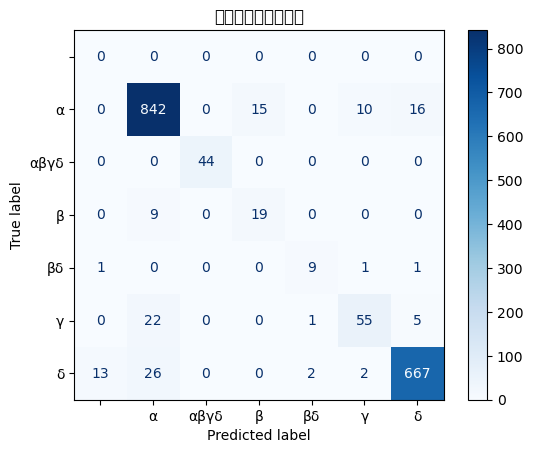

E:\anaconda\envs\huawei\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\anaconda\envs\huawei\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\anaconda\envs\huawei\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\anaconda\envs\huawei\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
E:\anaconda\envs\huawei\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  

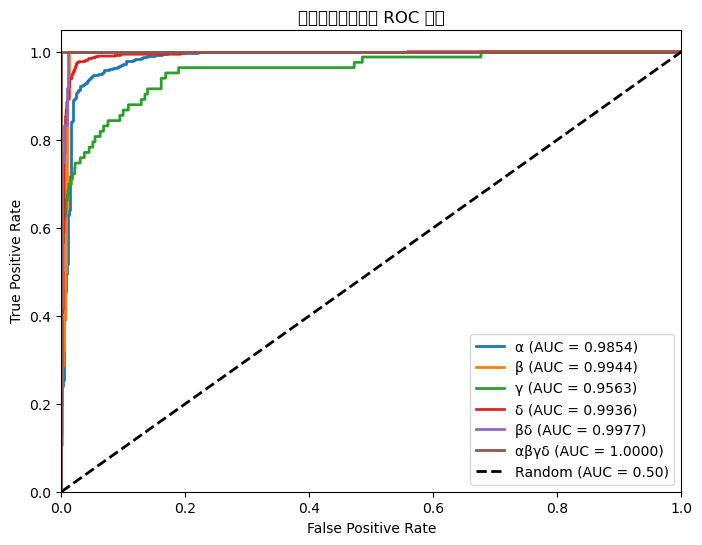

In [17]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from mindspore import Tensor, ops
import mindspore as ms

# 定义亚型标签映射（用于结果展示）
selective_map = {'α': 0, 'β': 1, 'γ': 2, 'δ': 3}
# SMILES 转指纹函数（与训练时一致）
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return None

def batch_smiles_to_fp(smiles_list):
    fps = []
    valid_indices = []
    for i, smile in enumerate(smiles_list):
        fp = smiles_to_fp(smile)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
        else:
            print(f"Invalid SMILES at index {i}: {smile}")
    return np.array(fps), valid_indices

# ------------------ 外部验证集预测 ------------------
# 加载外部验证集数据（确保文件路径正确）
data_val = pd.read_excel(r'D:\分类数据\0.1外部分类验证集.xlsx')

# 提取 SMILES 列和真实标签
smiles_list_val = data_val['smiles'].tolist()
true_labels = data_val['labels'].tolist()  # 假设真实标签为字符串，取值在 ["α", "β", "γ", "δ", "βδ", "αβγδ"]

fps_val, valid_indices_val = batch_smiles_to_fp(smiles_list_val)

# 使用训练时拟合的 scaler 对验证数据进行标准化
fps_val_scaled = scaler.transform(fps_val)

# 转换为 MindSpore 张量
fps_val_tensor = Tensor(fps_val_scaled, ms.float32)

# 模型预测前设为评估模式
model.set_train(False)
sel_out_val, multi_out_val = model(fps_val_tensor)

# 选择性任务：取 logits 中最大值对应的类别（未经过 softmax）
selective_pred_val = ops.Argmax(axis=1)(sel_out_val).asnumpy()
# 多任务输出：阈值 0.5 判定（直接获取 sigmoid 后的输出概率）
multi_pred_val = (multi_out_val.asnumpy() > 0.5).astype(int)

# 反向映射：将数值类别转为对应的标签字符
inv_selective_map = {v: k for k, v in selective_map.items()}

# 根据模型预测构建结果（仅用于分类报告与混淆矩阵显示）
pred_labels = []
results_val = []
for i, idx in enumerate(valid_indices_val):
    smile = smiles_list_val[idx]
    true_lab = true_labels[idx]
    # 当选择性任务预测为 0~3 时，认为为选择性抑制剂
    if selective_pred_val[i] < 4:
        predicted_label = inv_selective_map[selective_pred_val[i]]
    else:
        # 非选择性时，根据多任务预测结果进行拼接
        subtypes = ['α', 'β', 'γ', 'δ']
        predicted_label = ''.join([sub for sub, flag in zip(subtypes, multi_pred_val[i]) if flag])
    pred_labels.append(predicted_label)
    results_val.append({
        'SMILES': smile,
        'True Label': true_lab,
        'Predicted Label': predicted_label
    })

# 打印分类报告与混淆矩阵
print("外部验证集分类报告:")
print(classification_report(true_labels, pred_labels,digits=4))
unique_labels = sorted(set(true_labels) | set(pred_labels))
cm_val = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('外部验证集混淆矩阵')
plt.show()

# ------------------ ROC曲线及AUC计算 ------------------
# 定义类别顺序
class_names = ["α", "β", "γ", "δ", "βδ", "αβγδ"]

# 计算 selective 分支 softmax 概率
softmax = ops.Softmax(axis=1)
selective_probs = softmax(sel_out_val).asnumpy()  # shape: (N, 5)
# multi_out_val 已经是 sigmoid 概率，shape: (N, 4)
multi_probs = multi_out_val.asnumpy()

# 构造每个样本6个类别的预测概率
# 其中：前4个类别直接来自 selective_probs；最后两个类别为非选择性：
# p(βδ) = selective_probs[4] * [(1-p(α))*(p(β))*(1-p(γ))*(p(δ))]
# p(αβγδ) = selective_probs[4] * [p(α)*p(β)*p(γ)*p(δ)]
N = selective_probs.shape[0]
y_score = np.zeros((N, 6))
for i in range(N):
    # 选择性类别
    y_score[i, 0] = selective_probs[i, 0]  # α
    y_score[i, 1] = selective_probs[i, 1]  # β
    y_score[i, 2] = selective_probs[i, 2]  # γ
    y_score[i, 3] = selective_probs[i, 3]  # δ
    # 非选择性类别利用 multi_out 与 selective分支的非选择性概率（第5个神经元）
    non_sel_prob = selective_probs[i, 4]
    y_score[i, 4] = non_sel_prob * ((1 - multi_probs[i, 0]) * multi_probs[i, 1] * (1 - multi_probs[i, 2]) * multi_probs[i, 3])  # βδ
    y_score[i, 5] = non_sel_prob * (multi_probs[i, 0] * multi_probs[i, 1] * multi_probs[i, 2] * multi_probs[i, 3])             # αβγδ

# 构造真实标签的 one-hot 矩阵
y_true = np.zeros((N, 6))
for i, lab in enumerate(true_labels):
    if lab in class_names:
        idx = class_names.index(lab)
        y_true[i, idx] = 1

# 计算各类别的 ROC 曲线与 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8, 6))
for i, cls in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{cls} (AUC = {roc_auc[i]:.4f})')

# 绘制随机分类器的对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('外部验证集各亚型 ROC 曲线')
plt.legend(loc="lower right")
plt.show()


In [15]:
import pandas as pd

# ------------------ 保存混淆矩阵数据 ------------------
# 将混淆矩阵转换为 DataFrame，添加行列标签便于 Origin 绘图
cm_df = pd.DataFrame(cm_val, index=unique_labels, columns=unique_labels)
# 保存为 CSV 文件（例如：origin_confusion_matrix.csv）
cm_df.to_csv("D:\图数据\mindspore的多任务感知机external_confusion_matrix.csv", index=True)
print("混淆矩阵数据已保存到 'origin_confusion_matrix.csv'.")

# ------------------ 保存 ROC 曲线数据 ------------------
# 对于每个类别，将对应的假正例率（FPR）和真正例率（TPR）存为 CSV 文件，方便在 Origin 中绘制 ROC 曲线
for i, cls in enumerate(class_names):
    roc_df = pd.DataFrame({
        "FPR": fpr[i],
        "TPR": tpr[i]
    })
    file_name = f"origin_roc_curve_{cls}.csv"
    roc_df.to_csv(file_name, index=False)
    print(f"类别 {cls} 的 ROC 曲线数据已保存到 '{file_name}'.")

# ------------------ 保存 AUC 汇总数据 ------------------
# 将每个类别对应的 AUC 值整理后保存为 CSV 文件，便于 Origin 绘制汇总图或显示数值
auc_summary_df = pd.DataFrame({
    "Class": class_names,
    "AUC": [roc_auc[i] for i in range(len(class_names))]
})
auc_summary_df.to_csv("D:\图数据\mindspore的多任务感知机external_auc_summary.csv", index=False)
print("AUC 汇总数据已保存到 'origin_auc_summary.csv'.")


混淆矩阵数据已保存到 'origin_confusion_matrix.csv'.
类别 α 的 ROC 曲线数据已保存到 'origin_roc_curve_α.csv'.
类别 β 的 ROC 曲线数据已保存到 'origin_roc_curve_β.csv'.
类别 γ 的 ROC 曲线数据已保存到 'origin_roc_curve_γ.csv'.
类别 δ 的 ROC 曲线数据已保存到 'origin_roc_curve_δ.csv'.
类别 βδ 的 ROC 曲线数据已保存到 'origin_roc_curve_βδ.csv'.
类别 αβγδ 的 ROC 曲线数据已保存到 'origin_roc_curve_αβγδ.csv'.
AUC 汇总数据已保存到 'origin_auc_summary.csv'.


In [12]:
import pandas as pd

# ------------------ 保存混淆矩阵数据 ------------------
# 将混淆矩阵转换为 DataFrame，并添加行列标签
cm_df = pd.DataFrame(cm_val, index=unique_labels, columns=unique_labels)
# 保存为 CSV 文件
cm_df.to_csv(r"D:\图数据\mindspore的多任务感知机external_confusion_matrix.csv", index=True)
print("混淆矩阵数据已保存到 'external_confusion_matrix.csv'.")

# ------------------ 保存 ROC 曲线数据 ------------------
# 保存每个类别的 ROC 数据（fpr 和 tpr）
for i, cls in enumerate(class_names):
    roc_df = pd.DataFrame({
        "fpr": fpr[i],
        "tpr": tpr[i]
    })
    file_name = f"external_roc_curve_{cls}.csv"
    roc_df.to_csv(file_name, index=False)
    print(f"类别 {cls} 的 ROC 曲线数据已保存到 '{file_name}'.")

# ------------------ 保存 AUC 汇总数据 ------------------
auc_summary_df = pd.DataFrame({
    "Class": class_names,
    "AUC": [roc_auc[i] for i in range(len(class_names))]
})
auc_summary_df.to_csv(r"D:\图数据\mindspore的多任务感知机external_auc_summary.csv", index=False)
print("AUC 汇总数据已保存到 'external_auc_summary.csv'.")


混淆矩阵数据已保存到 'external_confusion_matrix.csv'.
类别 α 的 ROC 曲线数据已保存到 'external_roc_curve_α.csv'.
类别 β 的 ROC 曲线数据已保存到 'external_roc_curve_β.csv'.
类别 γ 的 ROC 曲线数据已保存到 'external_roc_curve_γ.csv'.
类别 δ 的 ROC 曲线数据已保存到 'external_roc_curve_δ.csv'.
类别 βδ 的 ROC 曲线数据已保存到 'external_roc_curve_βδ.csv'.
类别 αβγδ 的 ROC 曲线数据已保存到 'external_roc_curve_αβγδ.csv'.
AUC 汇总数据已保存到 'external_auc_summary.csv'.


In [14]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray
import mindspore as ms
from mindspore import Tensor, ops

# ------------------ 天然产物预测 ------------------
# 指定输入和输出文件路径
input_file = r"D:\天然产物的预测\Stacking的二分类7.xlsx"  # 输入文件路径（文件中应包含'smiles'和'名称'两列）
output_file = r"D:\天然产物的预测\mindspore多层感知机分类-Stacking的二分类7.xlsx"  # 输出文件路径（确保包含文件后缀.xlsx）

# 读取天然产物数据集，假设文件中包含 'smiles' 和 '名称' 列
data_np = pd.read_excel(input_file)
smiles_list_np = data_np['smiles'].tolist()
names_list_np = data_np['name'].tolist()  # 读取名称列

# 使用与训练时相同的指纹生成函数
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return None

def batch_smiles_to_fp(smiles_list):
    fps = []
    valid_indices = []
    for i, smile in enumerate(smiles_list):
        fp = smiles_to_fp(smile)
        if fp is not None:
            fps.append(fp)
            valid_indices.append(i)
        else:
            print(f"Invalid SMILES at index {i}: {smile}")
    return np.array(fps), valid_indices

# 生成指纹
fps_np, valid_indices_np = batch_smiles_to_fp(smiles_list_np)

# 使用训练时的 scaler 对数据进行标准化
fps_np_scaled = scaler.transform(fps_np)

# 转换为 MindSpore 张量
fps_np_tensor = Tensor(fps_np_scaled, ms.float32)

# 模型预测
model.set_train(False)
sel_out_np, multi_out_np = model(fps_np_tensor)
selective_pred_np = ops.Argmax(axis=1)(sel_out_np).asnumpy()
multi_pred_np = (multi_out_np.asnumpy() > 0.5).astype(int)

# 反向映射选择性标签
inv_selective_map = {v: k for k, v in selective_map.items()}

results_np = []
for i, idx in enumerate(valid_indices_np):
    smile = smiles_list_np[idx]
    # 获取原有名称
    name = names_list_np[idx]
    
    # 天然产物数据中通常没有真实标签，这里只输出模型预测结果
    if selective_pred_np[i] < 4:
        predicted_label = inv_selective_map[selective_pred_np[i]]
    else:
        subtypes = ['α', 'β', 'γ', 'δ']
        predicted_label = ''.join([sub for sub, flag in zip(subtypes, multi_pred_np[i]) if flag])
    
    results_np.append({
        '英文名称': name,
        'SMILES': smile,
        'Predicted Label': predicted_label
    })

# 保存预测结果到 Excel 文件
results_np_df = pd.DataFrame(results_np)
results_np_df.to_excel(output_file, index=False)
print(f"天然产物预测结果已保存到 {output_file}")


[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerator
[11:49:34] DEPRECATION WARNING: please use MorganGenerat

天然产物预测结果已保存到 D:\天然产物的预测\mindspore多层感知机分类-Stacking的二分类7.xlsx
